In [759]:
from functions import *
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import Ridge,LinearRegression,Lasso,ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
import pickle

In [760]:
df = pd.read_csv("dataset_clear.csv")

In [761]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'cat_bmi'],
      dtype='object')

In [762]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges","bmi"],axis=1)
y = df[target]



In [763]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8,stratify=X[["smoker"]])

In [764]:
numerical_features = [
       'age','children'
       ]
categorical_features = [
       'sex' , 'smoker', 'region',"cat_bmi"
       ]



In [765]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'),categorical_features),
    
])



In [766]:
dummy = DummyRegressor()

In [767]:
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [768]:
dummy.score(X_test,y_test)

-0.0010185684988295307

In [769]:
modelLR= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), LinearRegression())
modelLR.fit(X_train,y_train)
modelLR.score(X_train,y_train)


0.8588381209284734

In [770]:
modelLR.score(X_test,y_test)

0.9125868967386107

In [771]:
print(r2_score(modelLR.predict(X_test),y_test))
print(mean_squared_error(modelLR.predict(X_test),y_test,squared=False))

0.903276125273242
3549.8002458341366


In [772]:
modelRidge= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Ridge(alpha=2))
modelRidge.fit(X_train,y_train)
modelRidge.score(X_train,y_train)

0.8586096597292594

In [773]:
modelRidge.score(X_test,y_test)

0.9148320868155257

In [774]:
print(r2_score(modelRidge.predict(X_test),y_test))
print(mean_squared_error(modelRidge.predict(X_test),y_test,squared=False))

0.9037857493345745
3503.915699791672


In [775]:
# modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(max_iter=100000,random_state=42))
# parameters = {"lasso__alpha":np.linspace(0.1,100,1000)}
# randm_src = GridSearchCV(estimator=modelLasso, param_grid=parameters,scoring='r2',cv=5)
# randm_src.fit(X_train, y_train)

# modelLasso.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_

In [776]:
best={'lasso__alpha': 35.900000000000006}

In [777]:
modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(alpha=best["lasso__alpha"],max_iter=100000,random_state=42))
modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)


0.855390416919604

In [778]:
modelLasso.score(X_test,y_test)

0.9184589572469776

In [779]:
print(r2_score(modelLasso.predict(X_test),y_test))
print(mean_squared_error(modelLasso.predict(X_test),y_test,squared=False))

0.9061160815532053
3428.497020618863


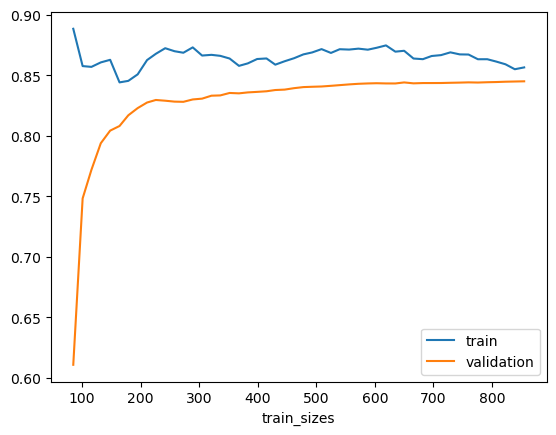

In [780]:
train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50))                                    
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [781]:
y_pred = modelLasso.predict(X_train)

In [782]:
residual = (y_pred - y_train).abs().sort_values(ascending=False)

In [783]:
residual.describe()

count     1069.000000
mean      2600.014220
std       3811.667124
min          3.627878
25%       1132.199983
50%       1585.148515
75%       2013.160642
max      23915.938278
Name: charges, dtype: float64

In [784]:
y_pred

array([ 9549.39388401, 16740.2171241 , 10896.96268052, ...,
        6703.40981003, 12769.62107145,  4201.81610512])

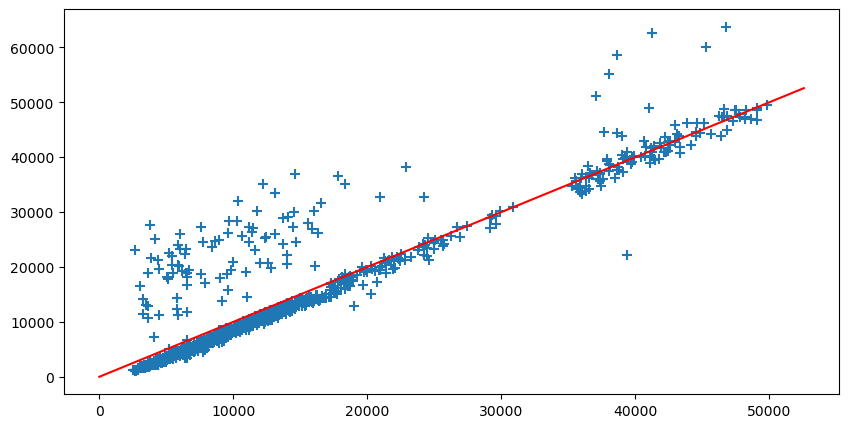

In [785]:
plt.subplots(figsize=(10, 5))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()


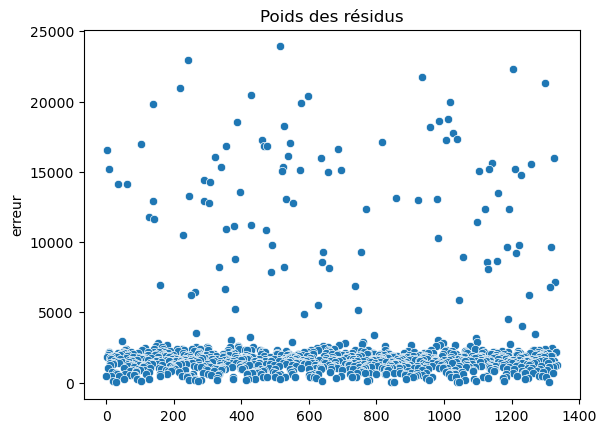

In [786]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [787]:
to_drop = residual[residual > 15000].index

In [788]:
X_train.loc[to_drop]

,age,sex,children,smoker,region,cat_bmi
516,20,male,1,no,southeast,obesity
242,55,female,1,no,southwest,overweight
1205,59,female,2,no,southwest,obesity
935,44,male,2,no,northeast,overweight
1299,45,male,0,yes,southeast,obesity
219,24,female,0,no,southeast,healthy
430,19,male,0,no,southwest,obesity
598,52,female,2,no,northwest,obesity
1018,21,female,2,no,northwest,obesity
577,31,female,1,yes,northeast,obesity


In [789]:


X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)



In [790]:


modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)



0.939885714488514

In [791]:


modelLasso.score(X_test,y_test)



0.9230527464716786

In [792]:
y_pred = modelLasso.predict(X_train)
residual = (y_pred - y_train).abs().sort_values()

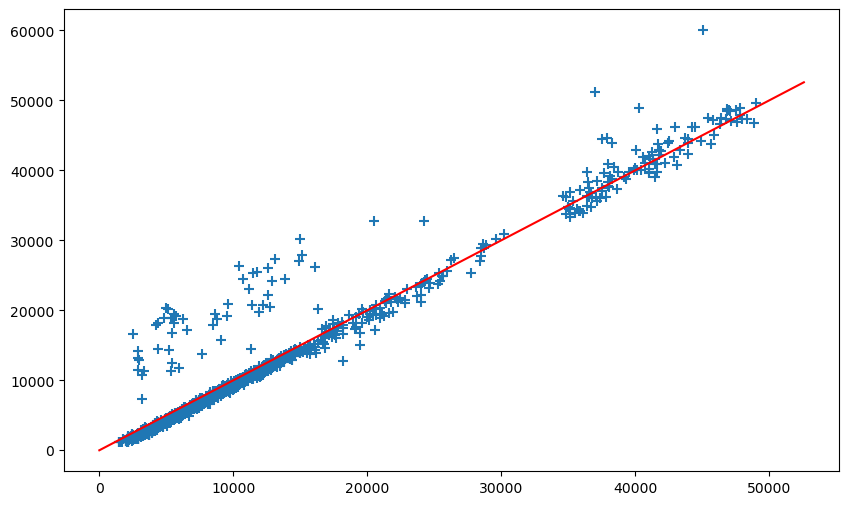

In [793]:
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()

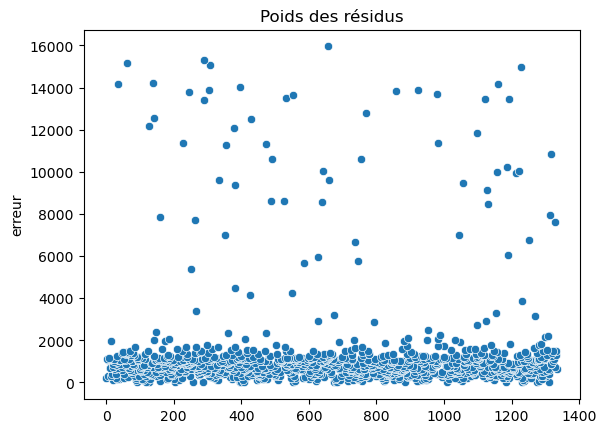

In [794]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [795]:
residual.describe()

count     1026.000000
mean      1418.838293
std       2487.728923
min          0.451174
25%        501.514653
50%        829.467851
75%       1155.942961
max      15953.495231
Name: charges, dtype: float64

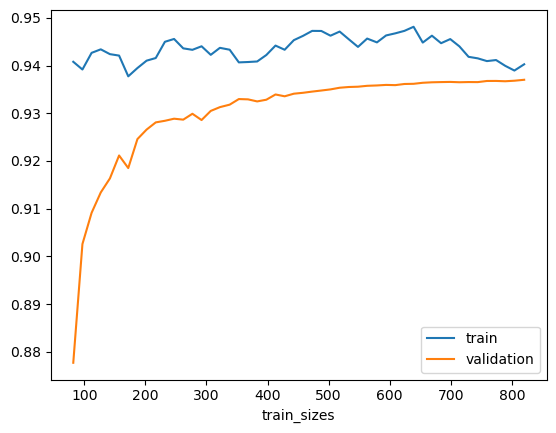

In [796]:

train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50))   
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [797]:
print(r2_score(modelLasso.predict(X_test),y_test))
print(mean_squared_error(modelLasso.predict(X_test),y_test,squared=False))

0.9137219269955
3330.5212389871813


In [798]:
pickle_out = open("modelLasso.pkl", "wb") 
pickle.dump(modelLasso, pickle_out) 
pickle_out.close()